In [204]:
%matplotlib inline

# First order model regression - LS & MLE
## Least squares method

### Generating data
Here we will generate a synthetic dataset from a first order model **$y = \theta_1 \cdot u + \theta_0$** and add some Gaussian noise to simulate sampling of the data, giving us: **$y_{measured} = \theta_1 \cdot u + \theta_0 + err$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1}$ = model parameters   
$err$ = measurement noise

Given the input $u$ and the measured data **$y_{measured}$** we will try to estimate the first oreder model coeffitienst $\hat{\theta}_{0,1}$ using the Least sqaures method.

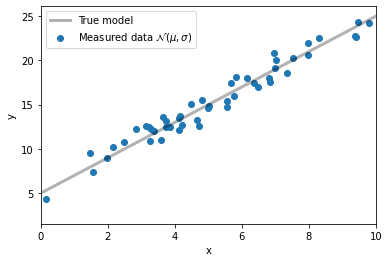

In [311]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters for 1D polynomial model 
theta_0 = 5.0
theta_1 = 2.0

# Generate noramlly distributed synthetic data from the model -> y = thetha_1 * u + theta_0 
N = 50
u = np.sort(np.random.normal(5,2,N))
y = theta_1 * u + theta_0

# Generate some Gaussian (normal) noise
mu, sigma = 0, 0.9 # mean and standard deviation
err = np.random.normal(mu, sigma, N)

# Measured output
y += err

plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(0, 10, 500)
plt.plot(u0, theta_1 * u0 + theta_0, "k", alpha=0.3, lw=3, label="True model")
plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

### Given the sampled data we can estimate the underlying model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (u^T\cdot u)^{-1}(u^T\cdot y)$

### Step 1 - rewrite the model in matrix form
$y_{measured} = \theta_1 \cdot u + \theta_0 + err = [ \theta_1 \; \theta_0 ] \cdot [u \; 1]^T + err$

In [312]:
u_vec = np.reshape(u,(N,1))
print(f"u :\n{u_vec[0:5]} \n")
u_vec = np.append(np.ones((N,1)), u_vec,axis=1)
print(f"1, u :\n{u_vec[0:5,:]}")

u :
[[-0.6 ]
 [ 0.15]
 [ 1.46]
 [ 1.54]
 [ 1.99]] 

1, u :
[[ 1.   -0.6 ]
 [ 1.    0.15]
 [ 1.    1.46]
 [ 1.    1.54]
 [ 1.    1.99]]


### Step 2   

calculate $(u^T \cdot u)^{-1}$

In [313]:
u_transpose_dot_u = np.dot(u_vec.T,u_vec)  # calculating dot product
u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
print(u_transpose_dot_u_inv)

[[ 0.11 -0.02]
 [-0.02  0.  ]]


### Step 3  

calculate $(u^T \cdot y)$

In [314]:
u_transpose_dot_y = np.dot(u_vec.T,y)  # calculating dot product
print(u_transpose_dot_y)

[ 754.5  4349.33]


### Step 4 

solve for $\hat{\mathbf{\theta}} = (u^T\cdot u)^{-1}(u^T\cdot y)$

LS - (theta_0_hat, theta_1_hat): (5.201296746591339, 1.9672847292584557)
True model - (theta_0, theta_1): (5.0, 2.0)


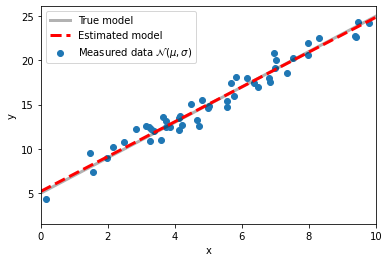

In [316]:
theta_hat = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
print(f"LS - (theta_0_hat, theta_1_hat): {theta_hat[0], theta_hat[1]}")
print(f"True model - (theta_0, theta_1): {theta_0, theta_1}")

plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(0, 10, 500)
plt.plot(u0, theta_1 * u0 + theta_0, "k", alpha=0.3, lw=3, label="True model")
plt.plot(u0, theta_hat[1] * u0 + theta_hat[0], "r--",  lw=3, label="Estimated model")
plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

## The same regression problem can be solved using Maximum likelihood estimation - MLE
In the special case where the sampled data and the measurement noise are normally distrubuted
the MLE solution is equal to the LS solution, the code below solves the presnted first order regression problem using maximum liklihood estimation. 

Source: http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/3-4-UnivarMLE.html

### Step 1 - define the log likelihood function to be minimized

In [317]:
def log_lik_norm(par_vec, y, x):
    
    # If the standard deviation prameter is negative, return a large value:
    if par_vec[2] < 0:
        return(1e8)
    # The likelihood function values:
    lik = norm.pdf(y, 
                   loc = par_vec[0] + par_vec[1] * x, 
                   scale = par_vec[2])
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

### Step 2 - use optimization solver to fit the data to the likelihood function

In [318]:
import scipy.optimize as optimize
from scipy.stats import norm

opt_res = optimize.minimize(fun = log_lik_norm, 
                            x0 = [0, 0, N], 
                            args = (y, u))

print(f"MLE - [theta_0_hat, theta_1_hat, sigma_err_hat]: {opt_res.x}")
print(f"True model - [theta_0 theta_1 sigma_err]: {theta_0, theta_1, sigma}")

MLE - [theta_0_hat, theta_1_hat, sigma_err_hat]: [5.2  1.97 0.95]
True model - [theta_0 theta_1 sigma_err]: (5.0, 2.0, 0.9)


## Comparing LS and MLE given normally distributed data and noise

In [320]:
print(f"MLE - (theta_0_hat, theta_1_hat): {opt_res.x[0], opt_res.x[1]}")
print(f"LS - (theta_0_hat, theta_1_hat):  {theta_hat[0], theta_hat[1]}")
print(f"True model - (theta_0 theta_1):   {theta_0, theta_1}")

MLE - (theta_0_hat, theta_1_hat): (5.201296677851695, 1.9672847325391316)
LS - (theta_0_hat, theta_1_hat):  (5.201296746591339, 1.9672847292584557)
True model - (theta_0 theta_1):   (5.0, 2.0)
